In [2]:
import pandas as pd
import numpy as np
import requests
import gzip
import matplotlib

#### PanelApp

In [3]:
panelapp_url = "https://panelapp.genomicsengland.co.uk/api/v1/panels/"
panel_list = requests.get(panelapp_url).json()["results"]

panelapp_ar_genes = set()
for panel in panel_list:
    panel_id = panel["id"]
    # print(f"Processing PanelApp panel {panel_id} - {panel['name']}")
    panel_detail_url = f"https://panelapp.genomicsengland.co.uk/api/v1/panels/{panel_id}/"
    detail = requests.get(panel_detail_url).json()
    for gene in detail.get("genes", []):
        # print(f"  Processing gene {gene['gene_data']['gene_symbol']}: {gene['mode_of_inheritance']}")
        if "mode_of_inheritance" in gene and "BIALLELIC" in gene["mode_of_inheritance"]:
            print(f"  Found biallelic gene {gene['gene_data']['gene_symbol']}")
            panelapp_ar_genes.add(gene["gene_data"]["gene_symbol"])

print(len(panelapp_ar_genes), "Autosomal recessive genes found in PanelApp")
panelapp_df = pd.DataFrame(sorted(panelapp_ar_genes), columns=["symbol"])
panelapp_df["source"] = "PanelApp"

  Found biallelic gene ACAD9
  Found biallelic gene ACADM
  Found biallelic gene ACADVL
  Found biallelic gene AGL
  Found biallelic gene ALDOA
  Found biallelic gene AMPD1
  Found biallelic gene ANO5
  Found biallelic gene CHKB
  Found biallelic gene COQ4
  Found biallelic gene COQ8A
  Found biallelic gene DGUOK
  Found biallelic gene DYSF
  Found biallelic gene ENO3
  Found biallelic gene ETFA
  Found biallelic gene ETFB
  Found biallelic gene ETFDH
  Found biallelic gene FDX2
  Found biallelic gene FKRP
  Found biallelic gene FLAD1
  Found biallelic gene GAA
  Found biallelic gene GBE1
  Found biallelic gene GMPPB
  Found biallelic gene GYG1
  Found biallelic gene GYS1
  Found biallelic gene HADHA
  Found biallelic gene HADHB
  Found biallelic gene LDHA
  Found biallelic gene LPIN1
  Found biallelic gene MLIP
  Found biallelic gene OBSCN
  Found biallelic gene PFKM
  Found biallelic gene PGAM2
  Found biallelic gene PGM1
  Found biallelic gene PYGM
  Found biallelic gene SGCA
  Foun

#### HGNC ID

In [4]:
# Define function for symbol conversion to Approved symbol from Alias or Previous symbol
fp_hgnc_all_results = "HGNC_BioMart_all_results.txt"
df_hgnc_biomart_data = pd.read_table(fp_hgnc_all_results, sep='\t', header=0)

approved_symbols = set(df_hgnc_biomart_data['Approved symbol'])
alias_symbols = set(df_hgnc_biomart_data['Alias symbol'])
prev_symbols = set(df_hgnc_biomart_data['Previous symbol'])

def convert_to_approved_symbol(x):
    """
    Convert gene symbol to Approved symbol.
    If the symbol is an Alias or Previous symbol, return the corresponding Approved symbol.
    If the symbol is not found, return NaN.
    """
    if x in approved_symbols:
        return x
    elif x in alias_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Alias symbol'] == x, 'Approved symbol'].values[0]
    elif x in prev_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Previous symbol'] == x, 'Approved symbol'].values[0]
    else:
        return np.nan

def fetch_hgnc_id_by_approved_symbol(x):
    """Fetch HGNC ID by Approved symbol."""
    if x in approved_symbols:
        return df_hgnc_biomart_data.loc[df_hgnc_biomart_data['Approved symbol'] == x, 'HGNC ID'].values[0]
    else:
        return np.nan

def drop_non_hgnc_id(df_hgnc_biomart_data: pd.DataFrame) -> pd.DataFrame:
    before = len(df_hgnc_biomart_data)
    df_hgnc_biomart_data = df_hgnc_biomart_data.dropna(subset=['HGNC_ID'])
    after = len(df_hgnc_biomart_data)
    print(f"Drop na | Before - After: {before} - {after} = {before - after}")
    return df_hgnc_biomart_data

def drop_duplicates_by_hgnc_id(df_hgnc_biomart_data: pd.DataFrame) -> pd.DataFrame:
    before = len(df_hgnc_biomart_data)
    df_hgnc_biomart_data = df_hgnc_biomart_data.drop_duplicates(subset='HGNC_ID')
    after = len(df_hgnc_biomart_data)
    print(f"Drop duplicated | Before - After: {before} - {after} = {before - after}")
    return df_hgnc_biomart_data

In [5]:
df_hgnc_biomart_data.head()

,HGNC ID,Status,Approved symbol,Alias symbol,Previous symbol
0,HGNC:5,Approved,A1BG,NaN,NaN
1,HGNC:37133,Approved,A1BG-AS1,FLJ23569,NCRNA00181
2,HGNC:37133,Approved,A1BG-AS1,FLJ23569,A1BGAS
3,HGNC:37133,Approved,A1BG-AS1,FLJ23569,A1BG-AS
4,HGNC:24086,Approved,A1CF,ACF,NaN


#### GenCC

In [6]:
# 1. データの読み込み
gencc_df = pd.read_csv("gencc-submissions.tsv", sep="\t")

# 2. AR遺伝子だけ抽出（'inheritance'列に'Autosomal recessive'が含まれる行）
ar_genes = gencc_df[gencc_df['moi_title'].str.contains("Autosomal recessive", na=False)]
ad_genes = gencc_df[gencc_df['moi_title'].str.contains("Autosomal dominant", na=False)]

# 3. 遺伝子シンボルの一意なリストを取得
ar_symbols = ar_genes['gene_symbol'].dropna().unique()
ad_symobls = ad_genes['gene_symbol'].dropna().unique()

# 4. データフレームに変換
gencc_ar_df = pd.DataFrame(ar_symbols, columns=["symbol"])
gencc_ar_df["source"] = "GenCC"
gencc_ad_df = pd.DataFrame(ad_symobls, columns=["symbol"])
gencc_ad_df["source"] = "GenCC"

# 5. シンボルをApproved symbolに変換
gencc_ar_df["approved_symbol"] = gencc_ar_df["symbol"].apply(convert_to_approved_symbol)
gencc_ad_df["approved_symbol"] = gencc_ad_df["symbol"].apply(convert_to_approved_symbol)

# 6. HGNC IDを取得
gencc_ar_df["HGNC_ID"] = gencc_ar_df["approved_symbol"].apply(fetch_hgnc_id_by_approved_symbol)
gencc_ad_df["HGNC_ID"] = gencc_ad_df["approved_symbol"].apply(fetch_hgnc_id_by_approved_symbol)

In [7]:
my_genes = pd.read_csv("eLoF_genes.tsv", sep="\t", dtype=str)
my_genes = my_genes.drop_duplicates(subset="HGNC_ID")
gencc_ar = gencc_ar_df.drop_duplicates(subset="HGNC_ID")
gencc_ad = gencc_ad_df.drop_duplicates(subset="HGNC_ID")

# merge the three DataFrames on HGNC_ID
merged = gencc_ar.merge(my_genes, on="HGNC_ID", how="left", indicator=True)
merged_ad = gencc_ad.merge(my_genes, on="HGNC_ID", how="left", indicator=True)



In [8]:
merged["covered"] = merged["_merge"].map({
    "both": "Covered",
    "left_only": "Not Covered",
    "right_only": "Not Applicable"  # 念のため。出現しないはず。
})

merged_ad["covered"] = merged_ad["_merge"].map({
    "both": "Covered",
    "left_only": "Not Covered",
    "right_only": "Not Applicable"  # 念のため。出現しないはず。
})

In [9]:
# 5. カバー率計算
covered = merged[merged["_merge"] == "both"]
covered_count = len(covered)
total_count = len(gencc_ar)
coverage_rate = covered_count / total_count

covered_ad = merged_ad[merged_ad["_merge"] == "both"]
covered_ad_count = len(covered_ad)
total_ad_count = len(gencc_ad)
coverage_ad_rate = covered_ad_count / total_ad_count

# 6. 出力
print(f"GenCC AR遺伝子数: {total_count}")
print(f"カバーされた遺伝子数: {covered_count}")
print(f"カバー率: {coverage_rate:.2%}")
print(f"GenCC AD遺伝子数: {total_ad_count}")
print(f"カバーされたAD遺伝子数: {covered_ad_count}")
print(f"カバー率: {coverage_ad_rate:.2%}")

GenCC AR遺伝子数: 3278
カバーされた遺伝子数: 1810
カバー率: 55.22%
GenCC AD遺伝子数: 2671
カバーされたAD遺伝子数: 1508
カバー率: 56.46%


In [10]:
merged_ad

,symbol,source,approved_symbol,HGNC_ID,HGNC_Approved_Symbol,pLI,LOEUF_gnomAD_v2.1.1,pHaplo,HIscore,Enhancer_Gnocchi,Mean_AlphaMissense_pathogenicity,Genovo_LOEUF_corrected,Curated_by_ClinGenSVI_group,Curated_from_G2P,_merge,covered
0,SKI,GenCC,SKI,HGNC:10896,SKI,0.99901,0.194,0.765926974259332,0.0,5.007183017,0.475441595,0.208910712,False,False,both,Covered
1,KIF1B,GenCC,KIF1B,HGNC:16636,KIF1B,1.0,0.171,0.995469536012031,NaN,4.089921252,0.618584418,NaN,False,False,both,Covered
2,CAMTA1,GenCC,CAMTA1,HGNC:18806,CAMTA1,1.0,0.172,0.999349405942027,3.0,3.445228086,0.510220929,0.068702408,True,True,both,Covered
3,A2ML1,GenCC,A2ML1,HGNC:23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,Not Covered
4,BRAF,GenCC,BRAF,HGNC:1097,BRAF,0.99995,0.209,0.995170913745456,1.0,1.646331328,NaN,NaN,False,False,both,Covered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,CCND1,GenCC,CCND1,HGNC:1582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,Not Covered
2667,SLC2A3,GenCC,SLC2A3,HGNC:11007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,Not Covered
2668,SEC24C,GenCC,SEC24C,HGNC:10705,SEC24C,1.0,0.174,0.942031781158102,NaN,1.426752189,0.485797627,0.138907261,False,False,both,Covered
2669,MDM2,GenCC,MDM2,HGNC:6973,MDM2,0.99981,0.164,0.960508247405816,NaN,2.102898191,0.34486023,0.10441742,False,False,both,Covered


In [11]:
gencc_ad_df

,symbol,source,approved_symbol,HGNC_ID
0,SKI,GenCC,SKI,HGNC:10896
1,KIF1B,GenCC,KIF1B,HGNC:16636
2,CAMTA1,GenCC,CAMTA1,HGNC:18806
3,A2ML1,GenCC,A2ML1,HGNC:23336
4,BRAF,GenCC,BRAF,HGNC:1097
...,...,...,...,...
2666,CCND1,GenCC,CCND1,HGNC:1582
2667,SLC2A3,GenCC,SLC2A3,HGNC:11007
2668,SEC24C,GenCC,SEC24C,HGNC:10705
2669,MDM2,GenCC,MDM2,HGNC:6973


In [12]:
# 欠損除去前にカテゴリ分布を確認
print(merged["covered"].value_counts())

# dropna 後の件数も確認
df_plot = merged.dropna(subset=["pLI", "LOEUF_gnomAD_v2.1.1", "covered"]).copy()
print(df_plot["covered"].value_counts())

covered
Covered           1810
Not Covered       1468
Not Applicable       0
Name: count, dtype: int64
covered
Covered           1801
Not Covered          0
Not Applicable       0
Name: count, dtype: int64


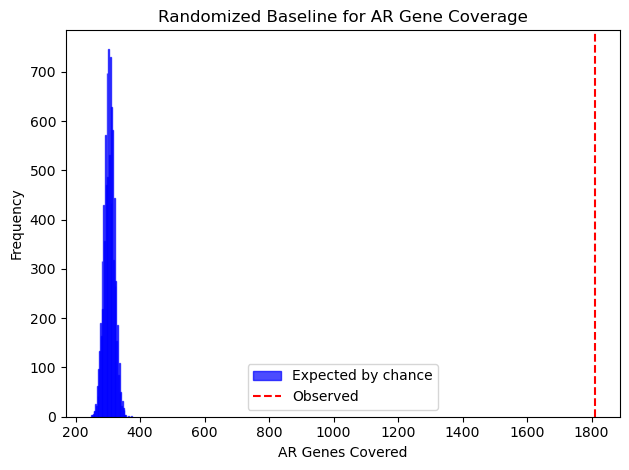

p-value = 9.999e-05


In [15]:
n_ar_total = len(gencc_ar["HGNC_ID"].unique())
n_test = len(my_genes["HGNC_ID"].unique())
n_sim = 10000

# ランダムに同じ数だけ抽出して、何個AR遺伝子が含まれるかを見る
hgnc_universe = set(df_hgnc_biomart_data["HGNC ID"].unique())  # 全ての"HGNC ID"の集合
ar_set = set(gencc_ar["HGNC_ID"])

matches = []
for _ in range(n_sim):
    sample = np.random.choice(list(hgnc_universe), size=n_test, replace=False)
    matches.append(len(ar_set.intersection(sample)))


In [ ]:

# シミュレーション結果
import matplotlib.pyplot as plt
plt.hist(matches, bins=50, alpha=0.7, color='blue', edgecolor='blue', label="Expected by chance")
plt.axvline(x=covered_count, color="red", linestyle="--", label="Observed")
plt.xlabel("AR Genes Covered")
plt.ylabel("Frequency")
plt.legend()
plt.title("Randomized Baseline for AR Gene Coverage")
plt.tight_layout()


plt.show()

pval = (np.sum(np.array(matches) >= covered_count) + 1) / (len(matches) + 1)
print(f"p-value = {pval:.4g}")

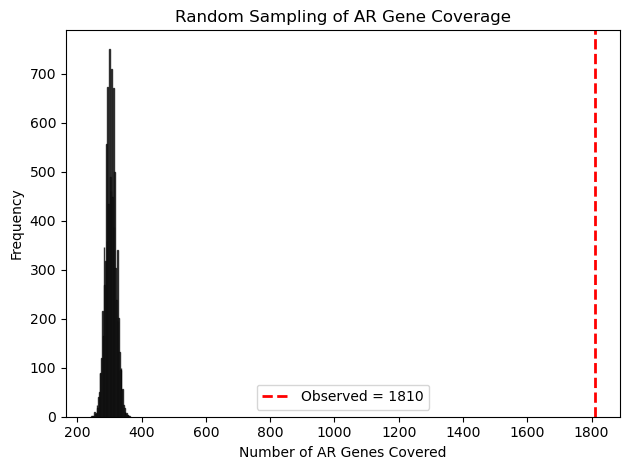

In [14]:

plt.hist(matches, bins=50, color='lightgray', edgecolor='black', alpha=0.8)
plt.axvline(x=covered_count, color="red", linestyle="--", linewidth=2, label=f"Observed = {covered_count}")
plt.xlabel("Number of AR Genes Covered")
plt.ylabel("Frequency")
plt.title("Random Sampling of AR Gene Coverage")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.violinplot(data=merged, x="covered", y="LOEUF_gnomAD_v2.1.1", inner="box")
plt.title("LOEUF distribution by AR gene coverage")
plt.tight_layout()
plt.show()

In [46]:
import seaborn as sns
import pandas as pd

df_violin = pd.DataFrame({
    "coverage": matches,
    "type": ["Random"] * len(matches)
}).append({
    "coverage": covered_count,
    "type": "Observed"
}, ignore_index=True)

plt.figure(figsize=(6, 5))
sns.violinplot(data=df_violin, x="type", y="coverage", inner="box", palette=["lightgray", "red"])
plt.title("AR Gene Coverage Distribution")
plt.ylabel("Number of AR Genes Covered")
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

In [45]:
import seaborn as sns
import pandas as pd

df_violin = pd.DataFrame({
    "coverage": matches,
    "type": ["Random"] * len(matches)
}).append({
    "coverage": covered_count,
    "type": "Observed"
}, ignore_index=True)

plt.figure(figsize=(6, 5))
sns.violinplot(data=df_violin, x="type", y="coverage", inner="box", palette=["lightgray", "red"])
plt.title("AR Gene Coverage Distribution")
plt.ylabel("Number of AR Genes Covered")
plt.tight_layout()
plt.show()


AttributeError: 'DataFrame' object has no attribute 'append'

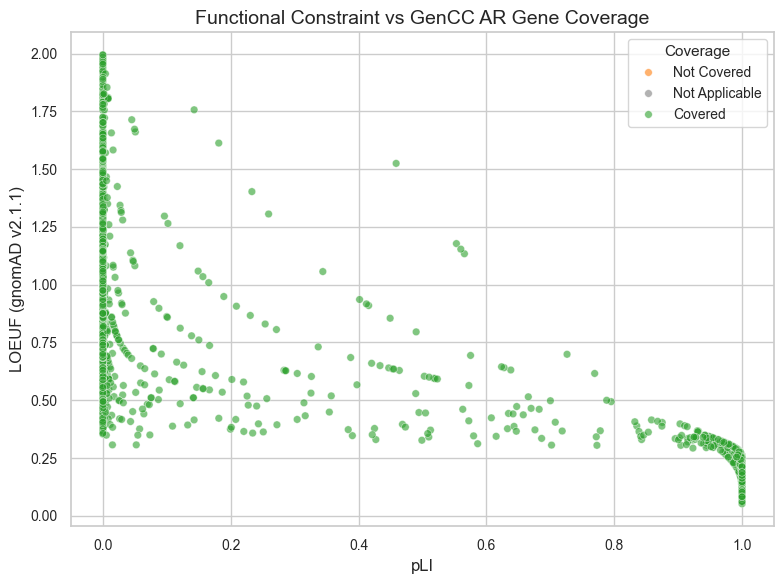

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 欠損を除外して、数値型に変換
df_plot = merged.dropna(subset=["pLI", "LOEUF_gnomAD_v2.1.1", "covered"]).copy()
df_plot["pLI"] = pd.to_numeric(df_plot["pLI"], errors="coerce")
df_plot["LOEUF_gnomAD_v2.1.1"] = pd.to_numeric(df_plot["LOEUF_gnomAD_v2.1.1"], errors="coerce")

# 描画スタイル調整
sns.set(style="whitegrid", context="notebook")

# カラーパレット指定（順序も明示）
palette = {
    "Covered": "#2ca02c",          # 緑
    "Not Covered": "#ff7f0e",      # オレンジ
    "Not Applicable": "#7f7f7f"    # グレー
}

# 散布図プロット
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,
    x="pLI",
    y="LOEUF_gnomAD_v2.1.1",
    hue="covered",
    palette=palette,
    alpha=0.6,
    s=30
)

# 軸とタイトル調整
plt.xlabel("pLI", fontsize=12)
plt.ylabel("LOEUF (gnomAD v2.1.1)", fontsize=12)
plt.title("Functional Constraint vs GenCC AR Gene Coverage", fontsize=14)
plt.legend(title="Coverage", loc="upper right", fontsize=10, title_fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


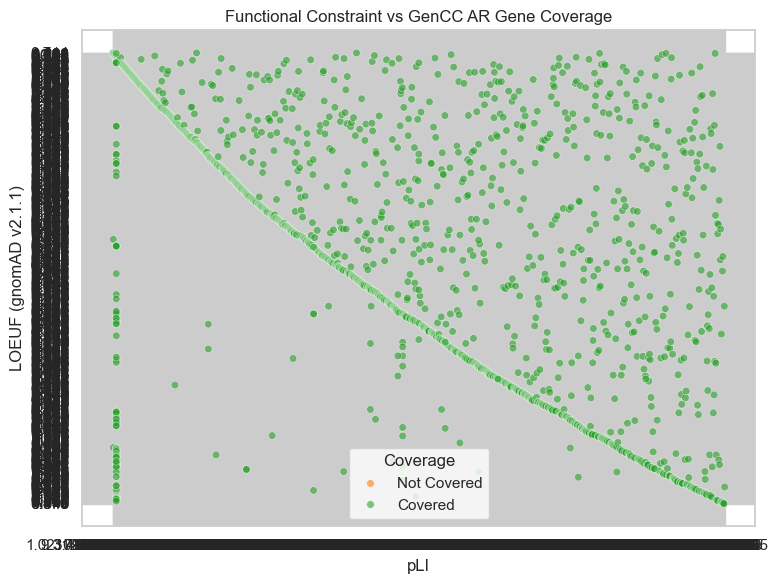

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# カラーパレット再定義
palette = {
    "Covered": "#2ca02c",       # 緑
    "Not Covered": "#ff7f0e"    # オレンジ
}

# 可視化対象を Covered + Not Covered のみ（Noneは除外）
merged["covered"] = merged["_merge"].map({
    "both": "Covered",
    "left_only": "Not Covered"
})

# 描画（欠損をそのまま含める）
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged,
    x="pLI",
    y="LOEUF_gnomAD_v2.1.1",
    hue="covered",
    palette=palette,
    alpha=0.6,
    s=30
)

plt.title("Functional Constraint vs GenCC AR Gene Coverage")
plt.xlabel("pLI")
plt.ylabel("LOEUF (gnomAD v2.1.1)")
plt.legend(title="Coverage")
plt.tight_layout()
plt.show()


In [11]:

# 4. gene_symbol（GenCC）と symbol（HGNC）を照合してHGNC IDを付加
ar_with_hgnc = pd.DataFrame({'gene_symbol': ar_symbols})
merged_df = ar_with_hgnc.merge(hgnc_df[['symbol', 'hgnc_id']], left_on='gene_symbol', right_on='symbol', how='left')

# 5. 出力（必要な列だけ）
merged_df[['gene_symbol', 'hgnc_id']].to_csv("gencc_AR_genes_with_HGNC.tsv", sep="\t", index=False)


KeyError: "None of [Index(['symbol', 'hgnc_id'], dtype='object')] are in the [columns]"

In [5]:
# 1. GenCCのデータ読み込み（公式TSV URLから直接でもOK）
gencc_file = "gencc-submissions.tsv"  # ローカルに保存したTSVファイル名
gencc_df = pd.read_csv(gencc_file, sep="\t")

# 2. autosomal recessive のみ抽出
ar_df = gencc_df[gencc_df["moi_title"].str.contains("Autosomal recessive", na=False)].copy()

# 3. 必要なカラムだけ抽出（例：gene_symbol, hgnc_id）
ar_df = ar_df[["gene_symbol", "hgnc_id"]].drop_duplicates()

# 4. HGNC ID を "HGNC:" 付きに整形（必要に応じて）
ar_df["hgnc_id"] = ar_df["hgnc_id"].apply(lambda x: f"HGNC:{int(x)}" if pd.notnull(x) else "")

# 5. 保存
ar_df.to_csv("gencc_ar_genes.tsv", sep="\t", index=False)


KeyError: "['hgnc_id'] not in index"